# 개요

- keras
  - 딥러닝용 **인터페이스**
  - **다른 엔진들 백엔드로 설정**하여서 딥러닝 개발을 수행할수 있다
  - 엔진이 바뀌더라도, 공통된 코드로 딥러닝 과정을 수행할수 있는 표준 인터페이스를 제공하는데 목적
  - 선택과 집중을 하게 해서 보다 하이 레벨 API를 통해서 보다 좋은 성과를 낼수 있는 쪽에 집중
  - **고수준 API 제공**
  - 문과생을 위한 딥러닝 도구
  - **keras(tensorflow 기반)**

- keara를 이용하여 최대한 심플하게 네트워크 구성
- 이렇게 학습된 모델을 flask에 가져와서 서비스에 바로 활용
- 조기 학습 종료
- 난수 고정



# 기본 모듈 가져오기

In [1]:
%tensorflow_version 1.x
import tensorflow as tf

tf.__version__

TensorFlow 1.x selected.


'1.15.2'

In [2]:
# 2017년도에 텐서플로우 하위 패키지로 통합되었다
# 백엔드 텐서플로우를 기반으로 케라스 코드를 기반으로 구현
from tensorflow import keras

In [3]:
keras.__version__

'2.2.4-tf'

# 난수 고정

- **난수의 시드가 동일하면 발생 시간이 상이하게 난수를 발생시켜도. 항상 동일한 패턴으로 난수가 발생된다**
  - 항상 동일한 조건을 발생시킨다
- 학습 수행시 최적화를 수행
  - 결과가 일관성 있게 나온다면, 튜닝 포인트를 잡을수 있다
  - 데이터 조합, 임계값(내부적)등등에서 사용하는 난수를 통제할 필요가 있다.
  - 이런 요인들을 난수를 통제함으로 **재현성**을 높이고, 특정요인이 결과에 미치는 영향을 판단할수 있다

In [4]:
# 시드 고정
seed_value = 0

In [5]:
# os 레벨
import os

os.environ['PYTHONJASHSEED'] = str(seed_value)

In [6]:
# 파이썬 레벨
import random

random.seed( seed_value )

In [7]:
# numpy 레벨
import numpy as np

np.random.seed( seed_value )

In [8]:
# 텐서플로우 레벨
tf.set_random_seed( seed_value )

In [9]:
# 케라스 레벨
from tensorflow.keras import backend

tf.set_random_seed( seed_value )
config = tf.ConfigProto( intra_op_parallelism_threads=1,
                         inter_op_parallelism_threads=1)
sess = tf.Session( graph=tf.get_default_graph(), config=config )

backend.set_session( sess )

# MNIST 데이터 준비

- keras 컨셉상 하위 엔진에 따라 조정할 부분이 존재하는데 => 이미지 데이터 포멧
  - **NHWC or NCHW**
  - 이미지 데이터의 경우는 엔진의 포멧에 따라 조정할 필요가 있다

In [10]:
from tensorflow.keras.datasets import mnist

In [11]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [12]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

- 케라스의 백엔드 엔진에서 이미지 데이터 포멧을 구한다|

In [13]:
# 데이터 형식 : NHWC, NCHW
fmt = backend.image_data_format()
fmt
# channels_last : NHWC
# channels_first : NCHW

'channels_last'

In [14]:
# 정답 0 ~ 9 => 원핫인코딩 작업
np.unique( y_train )

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [15]:
# 상수 정의 
PIXEL_H = X_train.shape[ 1 ]
PIXEL_W = X_train.shape[ 2 ]
PIXEL   = PIXEL_H * PIXEL_W
LABEL_NUM = len( np.unique( y_train ) )

PIXEL_H, PIXEL_W, PIXEL, LABEL_NUM

(28, 28, 784, 10)

In [16]:
# MNIST 입력 채널 수 1
INPUT_CHANNEL = 1

# 백엔드 엔진 기반으로 데이터 포멧을 설정 
# 백엔드 엔진이 바귀더라고, 코드가 변경되지 않게 구성
# 입력 데이터를 데이터 포멧에 맞게 구성한다
if fmt == 'channels_last': # NHWC
  # (60000, 28, 28) -> (60000, 28, 28, 1)
  # 3D -> 4D
  X_train = X_train.reshape( -1, PIXEL_H, PIXEL_W, INPUT_CHANNEL )
  X_test  = X_test.reshape( -1, PIXEL_H, PIXEL_W, INPUT_CHANNEL )
else: # NCHW
  # (60000, 28, 28) -> (60000, 1, 28, 28)
  # 3D -> 4D
  X_train = X_train.reshape( -1, INPUT_CHANNEL, PIXEL_H, PIXEL_W )
  X_test  = X_test.reshape( -1, INPUT_CHANNEL, PIXEL_H, PIXEL_W )

In [17]:
X_train.shape, X_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [18]:
# 부동 소수 변환 및 정규화 수행
X_train = X_train.astype('float32')
X_test  = X_test.astype('float32')

In [19]:
# 픽셀값 0.0 ~ 255.0
# 최대값 기준 정규화 처리
X_train = X_train / np.max( X_train )
X_test  = X_test  / np.max( X_train )

In [20]:
# 정답 데이터에 대한 원-핫 인코딩 처리
y_train = keras.utils.to_categorical( y_train, LABEL_NUM )
y_test  = keras.utils.to_categorical( y_test,  LABEL_NUM )

In [21]:
y_train.shape, y_test.shape, 

((60000, 10), (10000, 10))

# 신경망 구성

- 네트워크 구성
  - 신경망 구성(각측별 shape 구성)
  - 각 층별 요소배치(합성곱, 풀링, 과적합방지, 전결합,..반복)
  - shape 표를 작성 -> 파이토치에서 확인
- 작성
  - 객체 지향 스타일로 구성 
  - 절차적 코드로 구성

## 모듈 가져오기

In [22]:
# 1. 
from tensorflow.keras import models, layers, backend

In [23]:
# 1-1 백엔드 정보 확인
backend.backend(), backend.image_data_format(), backend.epsilon()

('tensorflow', 'channels_last', 1e-07)

## Sequential 준비 (연속적, 연쇄적 반응)

In [24]:
# 2. Sequential 객체 준비 -> 네트워크 -> 여기에 차곡 차곡 레이어를 추가한다
model = models.Sequential()

## 인공 신경망구성( add )

### 입력층

- 합성곱층 최초 구성시 입력층에 대한 내용이 들어가서 생략

### 합성곱층 1f

In [25]:
# 입력층  shape을 위해셔 구성
if fmt == 'channels_last': # NHWC
  input_shape = ( PIXEL_H, PIXEL_W, INPUT_CHANNEL )
else: # NCHW
  input_shape = ( INPUT_CHANNEL, PIXEL_H, PIXEL_W )

In [26]:
# W, b값은 API가 사용하는 기본값을 사용하겟다 
model.add( layers.Conv2D( 
  32,     # 합성곱층을 통과한 결과물의 출력채널수 1->32
  (5,5),  # 커널(필터)의 크기
  (1,1),  # 커널의 이동양:스트라이드
  'same', # 패딩의 타입
  activation  ='relu', # 활성화함수=> 산출물이 활성화맵
  # 첫번째 층을 구성하는것이므로, 입력층에 대한 표현이 필요
  input_shape = input_shape
  ) )

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


### 풀링층 1f

In [27]:
model.add( layers.MaxPool2D(
  pool_size = (2, 2),  # 커널의 크기
  strides   = None,    # None이면 스트라이드의 값은 커널크기와 동일하다
  padding   = 'same',  # 패딩값 
) )

In [28]:
model.add( layers.Dropout(0.1) )

### 합성곱층 2f

In [29]:
model.add( layers.Conv2D( 
  32*2,
  (5,5),
  #(1,1)  # 기본값은 (1,1)
  padding='same',
  activation='relu'
) )

### 풀링층 2f

In [30]:
model.add( layers.MaxPool2D( 
  padding   = 'same'
) )

In [31]:
model.add( layers.Dropout(0.1) )

### 전결합층

- tf에서 퍼셉트론으로 연결한 층은
  - layers.Dense()로 연결한다

In [32]:
# 4D -> 2D
model.add( layers.Flatten() )
# 2D : (7*7*64) => 2D : 1024
model.add( layers.Dense( 1024, activation='relu')   )

### 과적합 방지층(드롭아웃층)

In [33]:
# 0.1 : 학습 방해 비율
model.add( layers.Dropout( 0.1) )

### 출력층

In [34]:
model.add( layers.Dense( LABEL_NUM, activation='softmax') )

## 손실함수, 최적화, 예측, 평가(compile)

In [35]:
# 파라미터들은 문자열 OK, 실제함수도 OK
model.compile(  
  optimizer='rmsprop',                         # 최적화 도구 , adam, sgd,...
  loss=keras.losses.categorical_crossentropy,  # 손실함수
  metrics = ['accuracy']                       # 정확도
)

- 여기까지 코드가 tf 구성시 part1과 동일함

# 학습 (fit)

- 온라인/오프라인
- 배치/미니배치 =>batch_size(1회 학습시 사용하는 데이터량) -> GPU와 연관을 맺는다
- 전이
- 1 epoch => 1 세대(전체 데이터를 풀로 사용)

In [36]:
# 오프라인 학습, 미니배치학습, 
# 전체 풀 데이터를 10회(10세대) 학습하겠다
EPOCHS     = 10    
# 언제든지 정확도 성능을 보면서 조정 가능, 1 세대내에서 1회 학습시 사용하는 데이터량
BATCH_SIZE = 128   

In [37]:
if 0:
  # 단 설치된 NVIDA 제품 및 CUDA 버전에 따라 표현이 달라질수도 있다
  # 문자열이 변경되거나, 사전단계 추가되거나 할수 있다
  with tf.device('/device:GPU:0'):
    # GPU 학습
    hist = model.fit( 
      X_train, 
      y_train, 
      batch_size=BATCH_SIZE, 
      epochs=EPOCHS,
      # 텐서플로우 진행시 검증용 데이터로 평가를 하지 않았다 => 테스트 데이터로 100번째수행
      # 훈련용 데이터에서 20%를 검증용으로 사용하여 내부적으로 수행해라
      # 60000 = 48000(T) + 12000(V)
      validation_split=0.2,  
    )

  # 이미 2세대부터 99%에 육박했다 그 이후는 미세한 성능향상이나 변동이 없다
  # 더이상의 학습은 무의미 하다 
  # 적정 수준에 도달하면 학습을 마무리 해야 한다 -> 조기 학습 종료



```
Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 13s 263us/sample - loss: 0.1740 - acc: 0.9464 - val_loss: 0.0642 - val_acc: 0.9798
Epoch 2/10
48000/48000 [==============================] - 7s 139us/sample - loss: 0.0452 - acc: 0.9860 - val_loss: 0.0344 - val_acc: 0.9900
Epoch 3/10
48000/48000 [==============================] - 7s 145us/sample - loss: 0.0310 - acc: 0.9904 - val_loss: 0.0308 - val_acc: 0.9908
Epoch 4/10
48000/48000 [==============================] - 7s 143us/sample - loss: 0.0224 - acc: 0.9931 - val_loss: 0.0325 - val_acc: 0.9908
Epoch 5/10
48000/48000 [==============================] - 7s 143us/sample - loss: 0.0177 - acc: 0.9945 - val_loss: 0.0323 - val_acc: 0.9918
Epoch 6/10
48000/48000 [==============================] - 7s 142us/sample - loss: 0.0143 - acc: 0.9953 - val_loss: 0.0349 - val_acc: 0.9913
Epoch 7/10
48000/48000 [==============================] - 7s 144us/sample - loss: 0.0109 - acc: 0.9966 - val_loss: 0.0317 - val_acc: 0.9923
Epoch 8/10
48000/48000 [==============================] - 7s 145us/sample - loss: 0.0104 - acc: 0.9969 - val_loss: 0.0416 - val_acc: 0.9911
Epoch 9/10
48000/48000 [==============================] - 7s 143us/sample - loss: 0.0081 - acc: 0.9973 - val_loss: 0.0421 - val_acc: 0.9911
Epoch 10/10
48000/48000 [==============================] - 7s 145us/sample - loss: 0.0082 - acc: 0.9975 - val_loss: 0.0362 - val_acc: 0.9935
```



In [38]:
if 0:
  # CPU 학습
  model.fit( 
    X_train, 
    y_train, 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS,
    # 텐서플로우 진행시 검증용 데이터로 평가를 하지 않았다 => 테스트 데이터로 100번째수행
    # 훈련용 데이터에서 20%를 검증용으로 사용하여 내부적으로 수행해라
    # 60000 = 48000(T) + 12000(V)
    validation_split=0.2,  
  )

# 학습 개선-조기학습종료 도입

- 장점
  - 더이상 변동폭이 생기지 않기 때문에, 더이상의 학습은 무의미하다라고 판단
  - 미세 조정은 조기 학습 종료 객체에서 조절
  - 콜백으로 등록하여서 처리된다

In [39]:
from tensorflow.keras.callbacks import EarlyStopping

# 조기 학습 종료 처리하는 객체 생성
early_stop = EarlyStopping()

# 학습
with tf.device('/device:GPU:0'):    
  hist = model.fit( 
    X_train, 
    y_train, 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS,      
    validation_split=0.2,
    # 조기 학습 종료 추가
    callbacks = [ early_stop ]
  )

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 13s 271us/sample - loss: 0.1741 - acc: 0.9463 - val_loss: 0.0631 - val_acc: 0.9802
Epoch 2/10
48000/48000 [==============================] - 7s 148us/sample - loss: 0.0453 - acc: 0.9859 - val_loss: 0.0351 - val_acc: 0.9896
Epoch 3/10
48000/48000 [==============================] - 7s 146us/sample - loss: 0.0312 - acc: 0.9901 - val_loss: 0.0327 - val_acc: 0.9898
Epoch 4/10
48000/48000 [==============================] - 7s 146us/sample - loss: 0.0216 - acc: 0.9933 - val_loss: 0.0351 - val_acc: 0.9909


In [40]:
hist

In [41]:
# 테스트 데이터를 이용하여 예측
model.evaluate( X_test, y_test )

10000/10000 [==============================] - 1s 113us/sample - loss: 8.6346 - acc: 0.9917


[8.634619103918151, 0.9917]

# 시각화를 이용한 평가

- hist에 쌓인 데이터르 시각화(성능검토)

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline

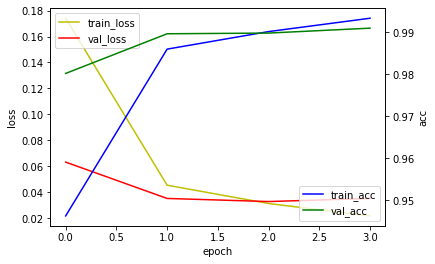

In [44]:
# hist.history-> loss, val_loss, acc, val_acc (손실, 정확도)
# 1. 시각화 도구 준비
fig, ax = plt.subplots()
# x축은 공통으로 사용, y축은 왼쪽. 오른쪽을 나눠서 각각 사용
# 왼쪽축 : loss, 오른쪽축 : acc
acc_ax = ax.twinx()

# 2. 플로팅
# 손실 플로팅: 우하향
ax.plot( hist.history['loss'], 'y', label='train_loss')
ax.plot( hist.history['val_loss'], 'r', label='val_loss')

# 정확도 플로팅 : 우상향
acc_ax.plot( hist.history['acc'], 'b'     , label='train_acc')
acc_ax.plot( hist.history['val_acc'], 'g' , label='val_acc')

# 부가 정보 표시
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
acc_ax.set_ylabel('acc')

# 범례 표기
ax.legend(loc='upper left')
acc_ax.legend()


# 3. 화면에 보여라
plt.show()

# 2세대에서 골든크로스가 발생되었고
# 이후 수렴하면서 조기학습 종료가 되었다

# 모델 덤프 (시스템 통합을 위한)

- 학습된 model을 파일로 저장

In [45]:
# 확장자는 취향것 -> 네트워크 구조(shape), W, b 이런 정도들이 저장된다
model.save('mnist_cnn.h5')

- 덤프된 모델을 로드하여 사용

In [45]:
from tensorflow.keras.models import load_model

In [47]:
loadedModel = load_model( 'mnist_cnn.h5')
loadedModel

OSError: ignored

In [ ]:
loadedModel.evaluate( X_test, y_test )

# mnist 데이터 1개 저장

- test.pgm 사용

# 서비스 구성(flask로 1개 파일로 구성)

In [ ]:
# 모델을 학습할때의 환경을 반드시 준수
# 텐서플로우 2.x에서 학습
# 산출물을 사용하는 서비스에 텐서플로우가 1.15가 설치되어 있다 
# 잓동않함, 오류발생

- 준비 
  - 로컬 PC 바탕화면에 kears_web_service 폴더생성
  - vs code 가동
  - 폴더 오픈 -> kears_web_service 

- 세팅
  - 가상환경 구축
  - vs code 가상환경으로 변경
  - 가상환경 활성화
  - 해당 환경에서
    - pip install flask
    - pip install tensorflow==1.15.0

In [43]:
!pip list

Package                       Version
----------------------------- --------------
absl-py                       0.12.0
alabaster                     0.7.12
albumentations                0.1.12
altair                        4.1.0
appdirs                       1.4.4
argcomplete                   1.12.3
argon2-cffi                   21.1.0
arviz                         0.11.2
astor                         0.8.1
astropy                       4.3.1
astunparse                    1.6.3
atari-py                      0.2.9
atomicwrites                  1.4.0
attrs                         21.2.0
audioread                     2.1.9
autograd                      1.3
Babel                         2.9.1
backcall                      0.2.0
backports.tempfile            1.0
backports.weakref             1.0.post1
beautifulsoup4                4.6.3
bleach                        4.0.0
blis                          0.4.1
bokeh                         2.3.3
Bottleneck                    1.3.2
branca    